In [39]:
using EVQueues, Plots, Distributions
#using Pkg; Pkg.instantiate()

In [40]:
#Parámetros del resto de la simulación
lambda=100.0;
mu=1;
gamma=1;
C=50.0;
Tfinal=100.0;

#Se agrega snaps para hacer animaciones
#snaps = collect(0.1:0.1:Tfinal);

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


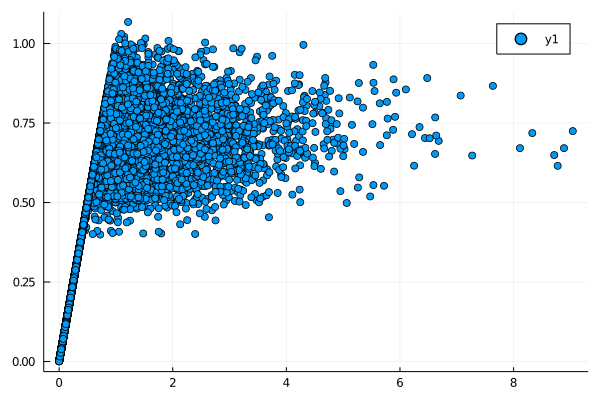

In [49]:
function hybridd_policy(evs,C)
    #Asigno el 70% de la potencia para EDF y el 30% para FIFO (asumo que el 30% no reportan deadline)

    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_fifo=0.0;
        p_edf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines)
        
        #Identifico los VE cuyos deadline no esta reportado
        k=findall(x->x==Inf, deadlines)
        
        if isempty(k)
            ev_edf=perm
        else
            j=findfirst(x->x==k[1], perm)
            #Separo en un nuevo array todos los vehiculos con deadline reportado
            ev_edf=perm[1:j-1]
        end
        
        ratio=length(ev_edf)/length(evs)
        C_edf=ratio*C;
        C_fifo=(1-ratio)*C;
               
        while p_fifo<C_fifo && i<=length(evs)
            if deadlines[i]==Inf
                alloc = min(evs[i].chargingPower,C_fifo-p_fifo);
                p_fifo=p_fifo+alloc;
                U[i]=alloc;
                i=i+1
            else
                i=i+1
            end
        end
        i=1
        while p_edf<C_edf && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
            p_edf=p_edf+alloc;
            U[perm[i]]=alloc;
            i=i+1
        end
    end
    return U;
end

#El 30% de los usuarios no reportan deadline
function no_deadline()
    random = rand()
    if random<0.3
        return Inf
    else
        return 0
    end
end

df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

reportedDeadlines = [d+no_deadline() for d in df[!,:salidas]]
reportedDeadlines = [d for d in df[!,:salidas]]
df[:salidaReportada] = reportedDeadlines

hybriddpolicy = ev_sim_trace(df,hybridd_policy,C,[Inf]);

compute_statistics!(hybriddpolicy);

hybriddpolicy_evs = sort(hybriddpolicy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
hybriddpolicy_evs = hybriddpolicy_evs[n:end-n]

#Guardo resultados de vehiculos
S = [ev.requestedEnergy for ev in hybriddpolicy_evs];
Sr = [ev.departureWorkload for ev in hybriddpolicy_evs];
Sa = S - Sr

scatter(S,Sa)



In [58]:
#Compare with EDF
function edf_policy(evs,C)
    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines);

        p=0.0;
        i=1;
        U=zeros(length(evs));

        #recorro el vector en orden de deadline y le asigno su potencia maxima o lo que falte pare llegar a C (puede ser 0)
        while p<C && i<=length(evs)
            alloc = min(evs[perm[i]].chargingPower,C-p);
            p=p+alloc;
            U[perm[i]]=alloc;
            i=i+1;
        end

    end
    return U;
end


EDF = ev_sim_trace(df,edf_policy,C,[Inf]);;
compute_statistics!(EDF);

EDF_evs = sort(EDF.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
EDF = EDF[n:end-n]

#Guardo resultados de vehiculos
S_EDF = [ev.requestedEnergy for ev in EDF_evs];
Sr_EDF = [ev.departureWorkload for ev in EDF_evs];
Sa_EDF = S_EDF - Sr_EDF

full_EDF = [ev.departureWorkload==0 for ev in EDF_evs];
full_hybrid = [ev.departureWorkload==0 for ev in hybrid_policy_evs];
a=full_EDF.*full_hybrid
b=full_EDF.+full_hybrid
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel="EDF",
            ylabel="Hybrid",
            title="Energy Received", legend=:bottomright)

scatter!(p,Sa_EDF[both_unfull.==true],Sa_hybrid[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_EDF[full_alg.==true],Sa_hybrid[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full EDF")
scatter!(p,Sa_EDF[full_alg_uncertain.==true],Sa_hybrid[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Hybrid")
scatter!(p,Sa_EDF[both_full.==true],Sa_hybrid[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


LoadError: MethodError: no method matching lastindex(::EVSim)
Closest candidates are:
  lastindex(!Matched::BenchmarkTools.Trial) at C:\Users\lucas\.julia\packages\BenchmarkTools\eCEpo\src\trials.jl:42
  lastindex(!Matched::Core.SimpleVector) at essentials.jl:600
  lastindex(!Matched::Cmd) at process.jl:639
  ...

In [28]:
#Compare with FIFO
FIFO = ev_sim_trace(df,C,fifo_policy,snapshots=[Inf]);
compute_statistics!(EDF);

FIFO_evs = sort(FIFO.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
FIFO = FIFO[n:end-n]

#Guardo resultados de vehiculos
S_FIFO = [ev.requestedEnergy for ev in FIFO_evs];
Sr_FIFO = [ev.departureWorkload for ev in FIFO_evs];
Sa_FIFO = S_FIFO - Sr_FIFO

full_FIFO = [ev.departureWorkload==0 for ev in FIFO_evs];
full_hybrid = [ev.departureWorkload==0 for ev in hybrid_policy_evs];
a=full_FIFO.*full_hybrid
b=full_FIFO.+full_hybrid
both_full = [i>0 for i in a];
both_unfull = [i==0 for i in b];

p = plot(  xlabel="FIFO",
            ylabel="Hybrid",
            title="Energy Received", legend=:bottomright)

scatter!(p,Sa_FIFO[both_unfull.==true],Sa_hybrid[both_unfull.==true],markershape=:circle,markersize=4,color=:blue,label="Not full")
scatter!(p,Sa_FIFO[full_alg.==true],Sa_hybrid[full_alg.==true],markershape=:circle,markersize=4,color=:red,label="Full FIFO")
scatter!(p,Sa_FIFO[full_alg_uncertain.==true],Sa_hybrid[full_alg_uncertain.==true],markershape=:circle,markersize=4,color=:yellow,label="Full Hybrid")
scatter!(p,Sa_FIFO[both_full.==true],Sa_hybrid[both_full.==true],markershape=:circle,markersize=4,color=:black,label="Both full")

LoadError: UndefVarError: fifo_policy not defined